In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
import display
import dataloader
from dataloader import ThermalData
import clustering
import anomaly_detection

画像データの取得

In [4]:
thermal_img_files = dataloader.get_img_files(dir_path="./images/modules",gray=False)
thermal_img_files_gray = dataloader.get_img_files(dir_path="./images/modules",gray=True)

In [5]:
type(thermal_img_files), len(thermal_img_files)

(dict, 158)

温度データの取得

In [6]:
data = ThermalData(thermal_img_files)

温度分布の確認（個別）

In [7]:
for k in list(data.temperature.keys())[:10]:
    print(k)    
    v = data.temperature[k]
    filepath = "./hist/hist_" + k
    display.display_distributions(v, filepath, show=False)

63.jpg
189.jpg
77.jpg
162.jpg
176.jpg
88.jpg
200.jpg
201.jpg
188.jpg
76.jpg


温度分布の確認

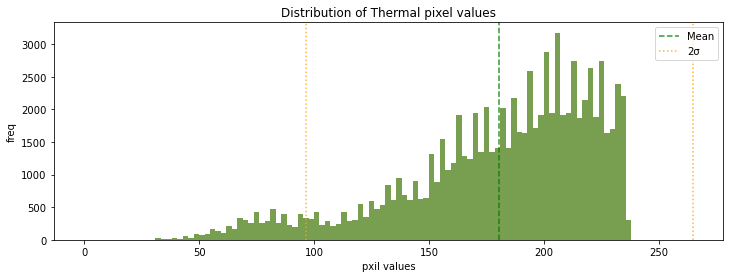

In [8]:
display.display_distributions(data.all_temperature, 
                              filepath = "hist_all_temperature.jpg")

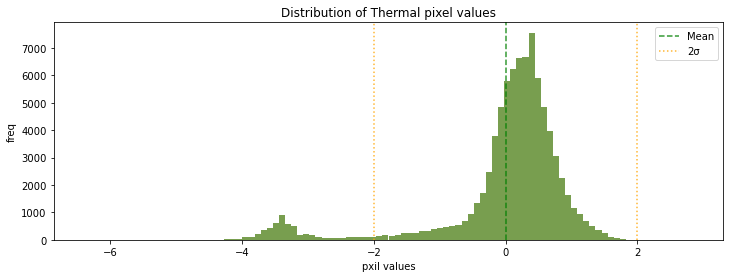

In [9]:
display.display_distributions(data.scaled_all_temperature,
                              filepath = "hist_scaled_all_temperature.jpg")

クラスタ分類モデルの作成

In [10]:
gmm = anomaly_detection.AnoGMM(data.all_temperature)

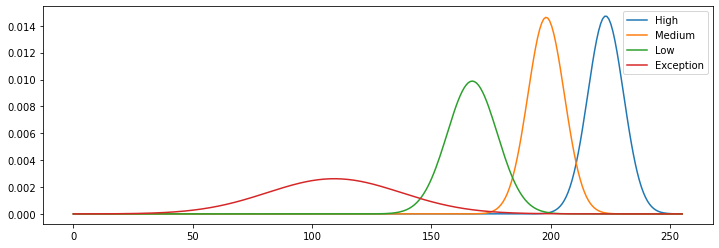

In [11]:
gmm.display()

個別画像の分析

In [12]:
input_file = "72.jpg"
#input_file = "12.jpg"
#input_file = "126.jpg"
#input_file = "130.jpg"

ピクセルのクラスタリング（by 温度＆位置）

In [13]:
clusters = clustering.TemperatureClusters(data.scaled_temperature_with_index[input_file], n_clusters=8)

In [14]:
clusters_temperature = clusters.get_clusters_data(data.temperature[input_file])
centers_temperature = np.stack([np.uint8(t.mean(axis=0)) for t in clusters_temperature])

クラスタリング結果の表示

In [15]:
img_clustered = centers_temperature[clusters.labels]
img_clustered = img_clustered.reshape(thermal_img_files[input_file].shape)

In [16]:
import matplotlib.cm as cm
from sklearn import preprocessing
mscaler = preprocessing.MinMaxScaler()
colors = cm.viridis(clusters.labels)[:, :3]
img_colored = np.uint8(mscaler.fit_transform(colors) * 255)
img_colored = img_colored.reshape(thermal_img_files[input_file].shape)
img_colored  = cv2.cvtColor(img_colored, cv2.COLOR_BGR2GRAY)

In [17]:
mask = data.scaled_temperature[input_file] > -2
mask = mask.reshape(thermal_img_files[input_file].shape)

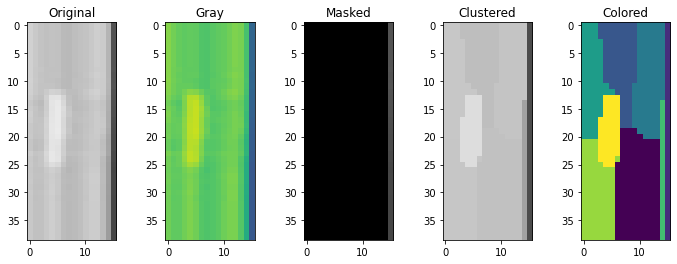

In [18]:
display.display_modules({
    "Original": thermal_img_files[input_file], 
    "Gray": thermal_img_files_gray[input_file],
    "Masked": (thermal_img_files[input_file]*~mask),
    "Clustered": img_clustered,
    "Colored": img_colored,
})

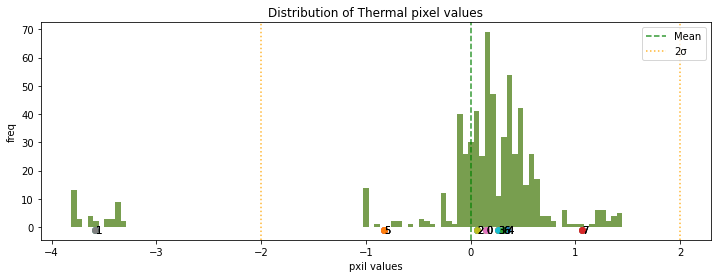

In [19]:
display.display_distributions(data.scaled_temperature[input_file], 
                              filepath = "test.jpg", cluster_centers = clusters.centers[:, :3])

クラスタの分類&異常タイプの特定

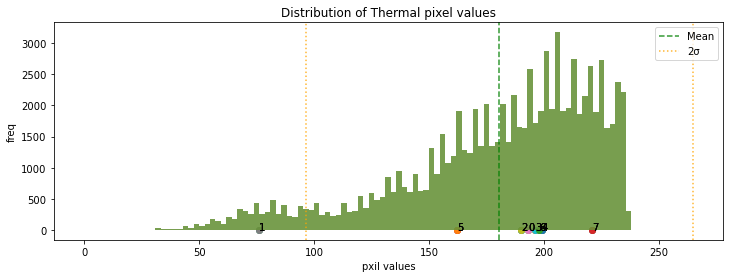

In [20]:
display.display_distributions(data.all_temperature, 
                              filepath = "test.jpg", cluster_centers = centers_temperature)

In [21]:
predicted_classes = gmm.predict(centers_temperature)
cluster_types = [ gmm.index2class[c] for c in predicted_classes ]
weights = np.array([ gmm.index2class[c] =="High" for c in predicted_classes[clusters.labels] ])    
module_type = anomaly_detection.detect_module_type(cluster_types, weights)

In [22]:
print("predicted_classses:",predicted_classes)
print("cluster_types:",cluster_types)
print("Hotspot weight:", weights.mean())
print("Module type:", module_type)

predicted_classses: [0 1 0 0 0 2 0 3]
cluster_types: ['Medium', 'Exception', 'Medium', 'Medium', 'Medium', 'Low', 'Medium', 'High']
Hotspot weight: 0.07211538461538461
Module type: Single-Hotspot


異常タイプの確認テスト

189.jpg Cluster-Hotspots
Cluster types: ['High', 'Exception', 'High', 'Medium', 'High', 'High', 'High', 'High']
Hotspot weights: 0.8709677419354839


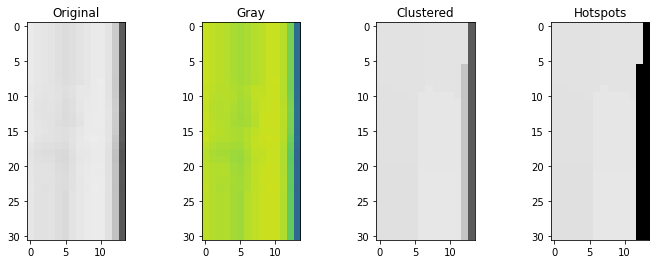

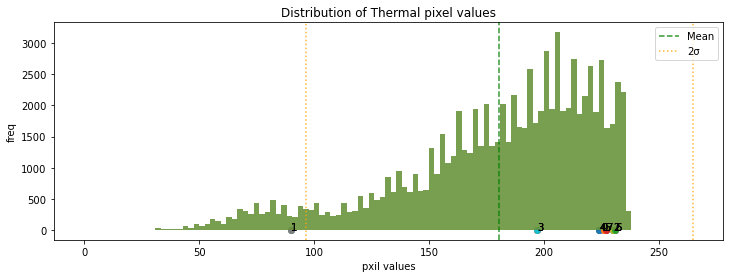

77.jpg Normal
Cluster types: ['Exception', 'Low', 'Exception', 'Low', 'Low', 'Low', 'Low', 'Low']
Hotspot weights: 0.0


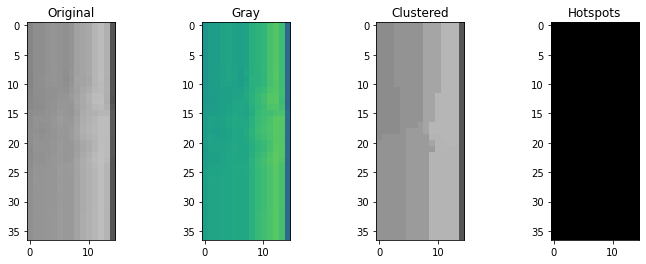

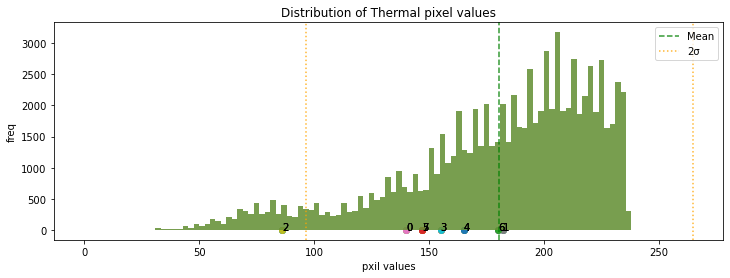

162.jpg Single-Hotspot
Cluster types: ['Low', 'Medium', 'Exception', 'High', 'Low', 'Exception', 'Medium', 'Low']
Hotspot weights: 0.15953947368421054


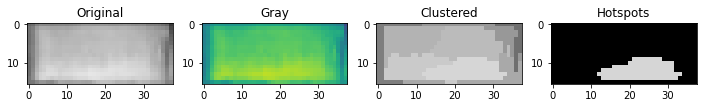

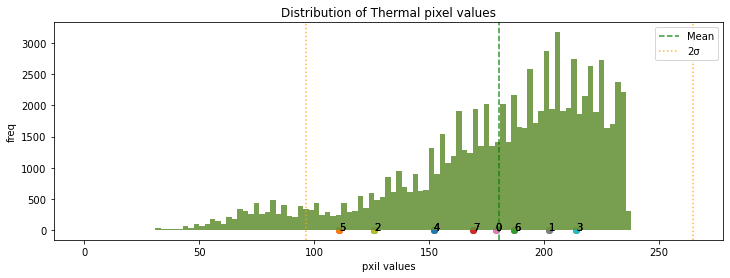

176.jpg Cluster-Hotspots
Cluster types: ['High', 'High', 'Exception', 'Exception', 'High', 'Low', 'High', 'Low']
Hotspot weights: 0.7770833333333333


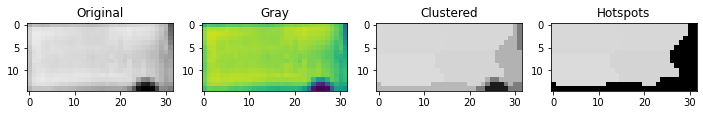

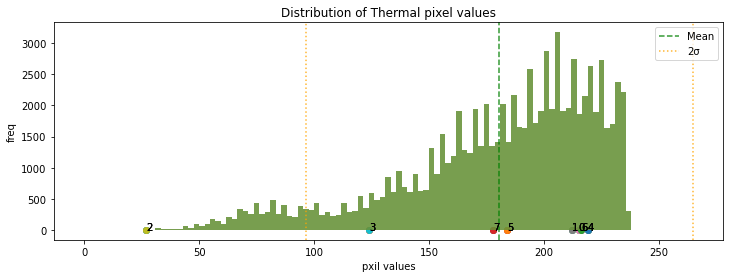

88.jpg Normal
Cluster types: ['Exception', 'Low', 'Medium', 'Exception', 'Low', 'Exception', 'Exception', 'Low']
Hotspot weights: 0.0


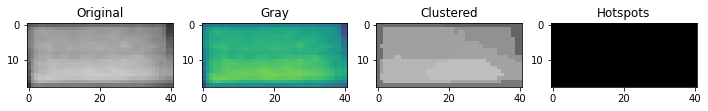

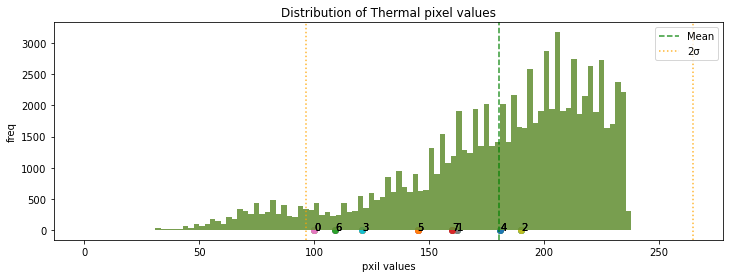

200.jpg Cluster-Hotspots
Cluster types: ['High', 'High', 'Exception', 'High', 'High', 'High', 'Medium', 'Exception']
Hotspot weights: 0.8861607142857143


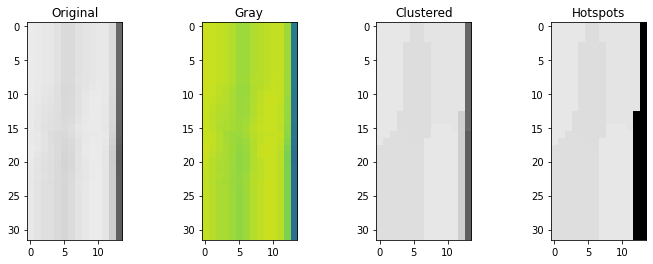

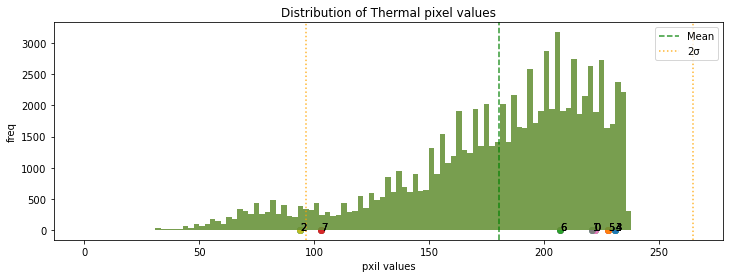

201.jpg Cluster-Hotspots
Cluster types: ['High', 'Exception', 'High', 'Medium', 'High', 'High', 'High', 'Exception']
Hotspot weights: 0.8794642857142857


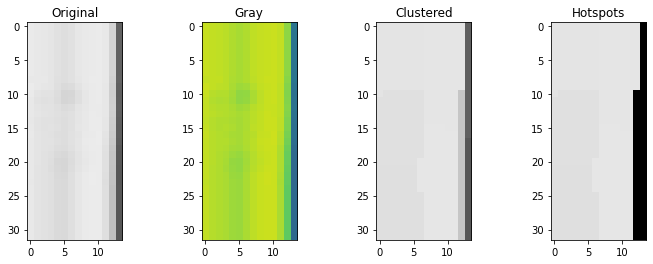

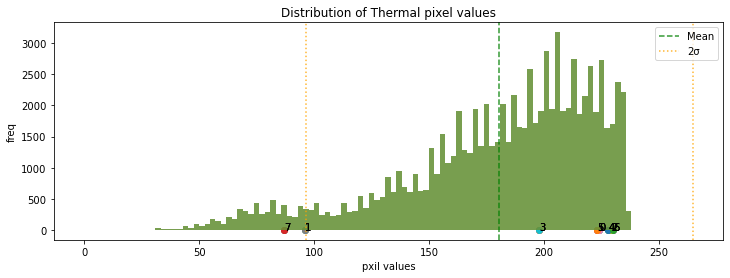

188.jpg Cluster-Hotspots
Cluster types: ['High', 'Exception', 'High', 'High', 'High', 'Low', 'High', 'Exception']
Hotspot weights: 0.8940092165898618


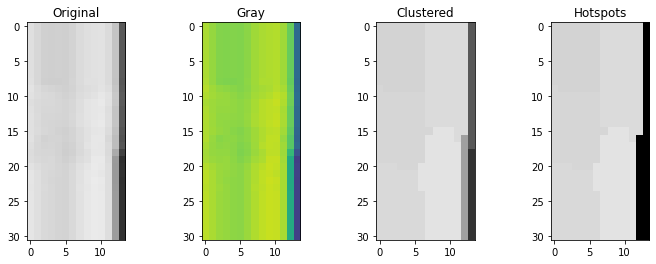

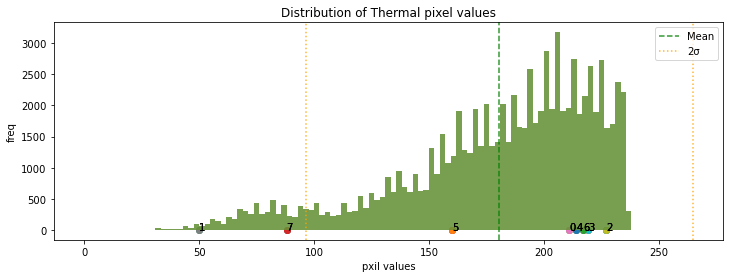

76.jpg Normal
Cluster types: ['Exception', 'Low', 'Exception', 'Low', 'Exception', 'Low', 'Exception', 'Low']
Hotspot weights: 0.0


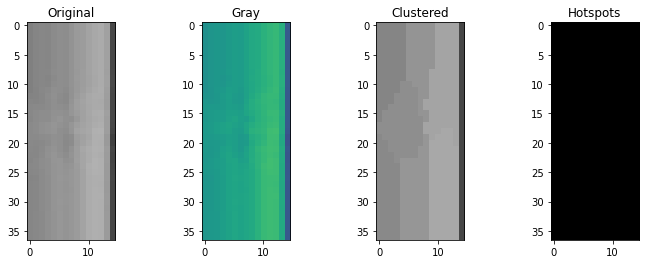

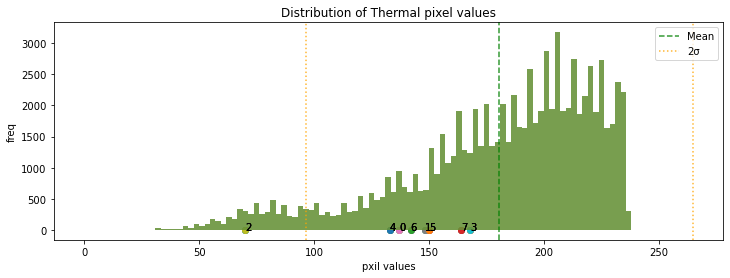

In [24]:
for k in list(data.temperature.keys())[1:10]:
    # -- kmeans ---
    clusters = clustering.TemperatureClusters(data.scaled_temperature_with_index[k], n_clusters=8)
    clusters_temperature = clusters.get_clusters_data(data.temperature[k])
    centers_temperature = np.stack([np.uint8(t.mean(axis=0)) for t in clusters_temperature])
    # -- gmm -- 
    predicted_classes = gmm.predict(centers_temperature)
    cluster_types = [ gmm.index2class[c] for c in predicted_classes ]
    # -- anomaly type --
    weights = np.array([ gmm.index2class[c] =="High" for c in predicted_classes[clusters.labels] ])
    module_type = anomaly_detection.detect_module_type(cluster_types, weights)
    print(k, module_type)
    print("Cluster types:",cluster_types)
    print("Hotspot weights:",weights.mean())
    # -- display -- 
    img_clustered = centers_temperature[clusters.labels] 
    img_hotspots = img_clustered * weights.reshape(-1,1)
    img_clustered = img_clustered.reshape(thermal_img_files[k].shape)
    img_hotspots = img_hotspots.reshape(thermal_img_files[k].shape)
    display.display_modules({
        "Original": thermal_img_files[k], 
        "Gray": thermal_img_files_gray[k],
        "Clustered": img_clustered,
        "Hotspots": img_hotspots,
    })
    display.display_distributions(
        data.all_temperature, 
        filepath = "hist_on_all_"+k,
        cluster_centers = centers_temperature
    )

In [ ]:
#ToDo
## 分布に対してGMMをオーバーラップしたい
## クラスタ異常を追加（面積ベース？）
## 異常部分へのマーキング（赤で囲む）